In [8]:
!pip install yfinance
import numpy as np
import pandas as pd
#used to grab the stock prices, with yahoo
#import pandas_datareader as web #pause use until yahoo issue is fixed
from pandas_datareader import data as web #for workaround until yahoo issue is fixed
import yfinance as yfin #for workaround until yahoo issue is fixed
yfin.pdr_override() #for workaround until yahoo issue is fixed
from datetime import datetime, date, timedelta
#to visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
#select start date for correlation window as well as list of tickers

now = date.today() - timedelta(days=1)
ttm = date.today() - timedelta(days=365)
now.strftime('%Y-%m-%d')
ttm.strftime('%Y-%m-%d')

'2020-07-12'

In [11]:
#select list of tickers from Yahoo Finance

symbols_list = ['BTC-USD', 'ETH-USD', 'PSP', '^GSPC', '^IXIC', 'IEF', 'DIA', 'GC=F', 'CL=F']
#array to store prices
symbols=[]

#pull price for each symbol in list defined above
for ticker in symbols_list: 
    #r = web.DataReader(ticker, 'yahoo', start) #pause use until yahoo issue is fixed
    r = web.get_data_yahoo(ticker, start=ttm, end=now)
    # add a symbol column
    r['Symbol'] = ticker 
    symbols.append(r)

# concatenate into df
df = pd.concat(symbols)
df = df[df.index.dayofweek < 5]
df = df.reset_index()
df = df[['Date', 'Close', 'Symbol']]
df = df.set_index('Date')
df['Symbol'] = df['Symbol'].replace({'BTC-USD': 'Bitcoin', 'ETH-USD': 'Ethereum', 'PSP': 'Private Equity', 
                                     '^GSPC': 'S&P 500', '^IXIC': 'Nasdaq', 'IEF': '7-10 Year Treasury Bond', 
                                     'DIA': 'Dow Jones', 'GC=F': 'Gold', 'CL=F': 'Oil'})

df_pivot = df.pivot(columns='Symbol', values='Close')
df_pivot = df_pivot.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
# calculate daily and annual returns of the stocks
returns_daily = df_pivot.pct_change()
returns_annual = returns_daily.mean() * 250
returns_std_dev = returns_annual.std()
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(symbols_list)
num_portfolios = 50000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(symbols_list):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in symbols_list]

# reorder dataframe columns
df = df[column_order]

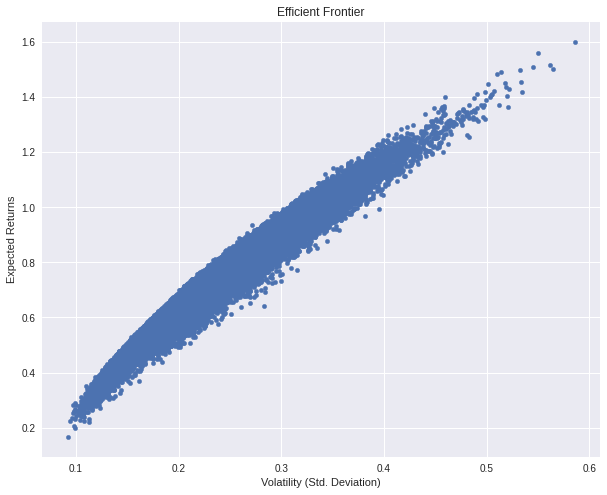

In [13]:
# plot the efficient frontier with a scatter plot
plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()